In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#import warnings
# すべての警告を無視
#warnings.filterwarnings("ignore")

In [ ]:
#!pip install tensorflow-addons

# <span style="color: blue;">🔹 Project Description</span>

In this project, we apply a Monet-like style to photos using the CycleGAN architecture. CycleGAN transforms images between two domains (photos and Monet's paintings) and back to the original domain, mimicking the target domain's style while retaining the original image features.

We will build the model based on Kaggle's tutorial and enhance the quality of generated images by incorporating the following four modifications:

- **Using PatchGAN for the discriminator:**
    - This GAN evaluates the authenticity of small regions called patches instead of the entire image.
    - With fewer parameters, the computational load is reduced, potentially speeding up the training process.
    - It captures local features more effectively, potentially improving the quality of the generated images.

- **Using LSGAN (Least Squares GAN) and modifying the loss function:**
    - This GAN uses adversarial loss based on mean squared error.
    - It tends to stabilize training and is less prone to mode collapse.

- **Applying data augmentation:**
    - Random horizontal flipping and random rotation are applied to the training data.
    - Increasing the variety of training data helps prevent overfitting and enhances the model's generalization performance.

- **Implementing early stopping:**
    - Training will halt when validation loss stops improving to prevent overfitting.

## <span style="color: blue;">🔹 Introduction and Setup</span>

- Import necessary packages.
- Perform performance tuning.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from kaggle_datasets import KaggleDatasets

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

2024-06-22 01:46:43.719401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 01:46:43.719482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 01:46:43.986173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2 Physical GPUs, 1 Logical GPUs
Number of replicas: 1
2.15.0


## <span style="color: blue;">🔹 Data Preprocessing and Visualization</span>

**`Data Structure`**
- monet_jpg: 300 images of Monet paintings in 256x256 size (JPEG format)
- monet_tfrec: 300 images of Monet paintings in 256x256 size (TFRecord format)
- photo_jpg: 7028 photos in 256x256 size (JPEG format)
- photo_tfrec: 7028 photos in 256x256 size (TFRecord format)

**`Data Preprocessing`**
- Set the number of channels to 3 for RGB images.
- Scale the images to the range [-1, 1].
- As we are using a generative model, labels and image IDs are not needed, so only the images are returned from the TFRecords.

**`Data Visualization`**
- Visualize and confirm the data.

In [2]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1).repeat()
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1).repeat()

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
])

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


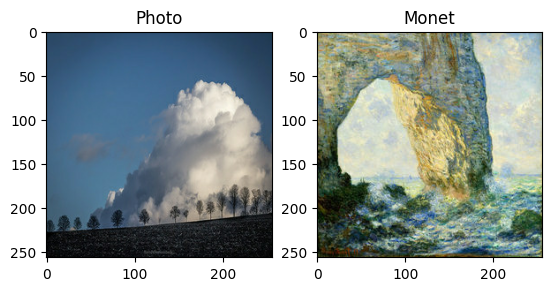

In [3]:
plt.subplot(121)  
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.show()

## <span style="color: blue;">🔹 Building the Generator</span>

**`Generator Explanation`**
- The CycleGAN generator adopts the U-Net architecture. This structure facilitates the process of converting a photo into a Monet-style painting and then reconverting it back into the original photo. The goal of the training process is to minimize the difference between the original photo and the reconverted photo (cycle consistency loss). This ensures that the generated image retains as much information from the original photo as possible while reflecting the Monet-style transformation.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=(input_shape[-1],), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.gamma * (inputs - mean) / tf.sqrt(variance + self.epsilon) + self.beta

    def get_config(self):
        config = super(InstanceNormalization, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        result.add(InstanceNormalization())
    
    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    
    result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## <span style="color: blue;">🔹 Building the Discriminator</span>

**`PatchGAN Discriminator`**

- The PatchGAN discriminator evaluates how close the generated image is to a real Monet painting, by examining small regions called patches. By assessing the image on a patch-by-patch basis, it captures local features effectively, improving the quality of the generated images.

- The discriminator combines convolutional layers with ZeroPadding2D layers, progressively reducing the patch size while outputting a matrix where each value represents the probability of each patch being real.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        result.add(InstanceNormalization())
    
    result.add(layers.LeakyReLU())

    return result

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3) # (bs, 16, 16, 512)
    
    zero_pad1 = layers.ZeroPadding2D()(down4) # (bs, 18, 18, 512)
    
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 15, 15, 512)
    
    norm1 = InstanceNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 17, 512)
    
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 14, 14, 1)
    
    return tf.keras.Model(inputs=inp, outputs=last)

discriminator = Discriminator()

## <span style="color: blue;">🔹 CycleGAN Model Training</span>

### Loss Functions
- **LSGAN (Least Squares GAN):** Uses Mean Squared Error loss instead of Binary Crossentropy loss, which helps stabilize training and reduces mode collapse.
- **Cycle Consistency Loss:** Measures the loss when the generator converts an image to another domain and then back to the original domain, ensuring high conversion accuracy.
- **Identity Loss:** Encourages the generator to output images close to the input when given images from the target domain, helping maintain color and structure.

### Optimization Algorithm
- **Adam:** Ensures fast and stable convergence.

### Early Stopping
- **Early Stopping:** Stops training when there is no improvement in the validation loss to prevent overfitting.

### Training Settings
- **Number of Epochs:** Up to 100 epochs, with early stopping based on validation loss.
- **Batch Size:** Set to 1.
- **Steps per Epoch:** 500 steps per epoch.

## <span style="color: blue;">🔹 Definition of CycleGAN Model</span>

The CycleGAN model consists of generators and discriminators for transforming photos to Monet paintings and vice versa. The generators are trained using Adversarial Loss, Cycle Consistency Loss, and Identity Loss. The model improves conversion accuracy by transforming a photo to another domain and then back to the original domain. The discriminators evaluate the authenticity of the generated images, ensuring high-quality image transformation.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## <span style="color: blue;">🔹 Loss Functions</span>

- **Discriminator Loss**: Calculates the mean squared error by comparing real images with 1 and generated images with 0, then takes the average as the loss.
- **Generator Loss in LSGAN**: Trains the generator to make the generated images appear as real as possible.
- **Cycle Consistency Loss**: Measures the difference (L1 norm) between the original image and the image converted to another domain and then back to the original domain.
- **Identity Loss**: Computes the difference (L1 norm) between the input and output when the same domain image is input into the generator.

In [9]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(generated), generated)
    return 0.5 * (real_loss + generated_loss)

def generator_loss(generated):
    return tf.keras.losses.MeanSquaredError()(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss1

def identity_loss(real_image, same_image, lambda_cycle):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_cycle * 0.5 * loss

## <span style="color: blue;">🔹 Model Compilation and Training</span>

The model training process utilizes the Adam optimizer. To prevent overfitting, early stopping is implemented, which halts training when the loss on the validation data no longer improves. The training process is capped at a maximum of 100 epochs, but it can terminate earlier if the early stopping conditions are met. The batch size is set to 1, and each epoch comprises 500 steps.

In [11]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

    monet_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1).map(lambda x: data_augmentation(x), num_parallel_calls=AUTOTUNE).repeat()
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1).map(lambda x: data_augmentation(x), num_parallel_calls=AUTOTUNE).repeat()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='monet_gen_loss', patience=10, restore_best_weights=True, mode='min'
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100,
    callbacks=[early_stopping],
    steps_per_epoch=500
)

Epoch 1/100


I0000 00:00:1719021022.670453     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 228s 213ms/step - monet_disc_loss: 0.4818 - monet_gen_loss: 4.9511 - photo_disc_loss: 0.4918 - photo_gen_loss: 5.0540
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - monet_disc_loss: 0.2747 - monet_gen_loss: 2.5747 - photo_disc_loss: 0.2731 - photo_gen_loss: 2.5787
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - monet_disc_loss: 0.2678 - monet_gen_loss: 2.2261 - photo_disc_loss: 0.2679 - photo_gen_loss: 2.2329
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 211ms/step - monet_disc_loss: 0.2535 - monet_gen_loss: 2.0783 - photo_disc_loss: 0.2595 - photo_gen_loss: 2.1019
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 211ms/step - monet_disc_loss: 0.2547 - monet_gen_loss: 1.9819 - photo_disc_loss: 0.2547 - photo_gen_loss: 1.9844
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - monet_disc_loss: 0.2474 - monet_gen_loss: 1.9162 - photo_disc_loss: 0.2499 - photo_gen_loss: 1.9349
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step -

Epoch 31/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 211ms/step 
- monet_disc_loss: 0.2263 
- monet_gen_loss: 1.5336 
- photo_disc_loss: 0.2002 
- photo_gen_loss: 1.6227

Epoch 45/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step 
- monet_disc_loss: 0.2274 
- monet_gen_loss: 1.5989 
- photo_disc_loss: 0.2054 
- photo_gen_loss: 1.6803

Epoch 20/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step 
- monet_disc_loss: 0.2275 
- monet_gen_loss: 1.8021 
- photo_disc_loss: 0.2327 
- photo_gen_loss: 1.7966

Epoch 15/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step 
- monet_disc_loss: 0.2356 
- monet_gen_loss: 1.8502 
- photo_disc_loss: 0.2382 
- photo_gen_loss: 1.8572

Epoch 50/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step 
- monet_disc_loss: 0.2478 
- monet_gen_loss: 2.7315 
- photo_disc_loss: 0.2613 
- photo_gen_loss: 2.7118

Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step 
- monet_disc_loss: 0.2994 
- monet_gen_loss: 2.8366 
- photo_disc_loss: 0.3081 
- photo_gen_loss: 2.8589

Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step 
- monet_disc_loss: 0.3416 
- monet_gen_loss: 7.2821 
- photo_disc_loss: 0.4286 
- photo_gen_loss: 7.4678


## <span style="color: blue;">🔹 Evaluation and Analysis</span>

To assess the quality of the generated images, both quantitative and qualitative evaluations are used.

- **Quantitative Evaluation**: MiFID (Memorization-informed Fréchet Inception Distance) is employed. This metric, based on FID, also considers the degree of memorization of the training data. A lower MiFID score indicates higher quality image generation.

- **Qualitative Evaluation**: The generated images are visually inspected to determine if the style of Monet's paintings is effectively reproduced and if the artistic textures are well-represented.

In [15]:
import tensorflow as tf
import tensorflow_gan as tfgan
import numpy as np

def calculate_inception_activations(images):
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))
    preprocessed_images = tf.keras.applications.inception_v3.preprocess_input(images)
    activations = inception_model.predict(preprocessed_images)
    return activations

def calculate_fid(real_activations, generated_activations):
    fid = tfgan.eval.frechet_classifier_distance_from_activations(real_activations, generated_activations)
    return fid

def sample_images(dataset, num_samples):
    sampled_images = []
    for img in dataset.take(num_samples):
        sampled_images.append(img[0].numpy())
    return np.array(sampled_images)

real_images = sample_images(photo_ds, 100)
generated_images = sample_images(photo_ds.map(lambda x: monet_generator(x, training=False)), 100)

real_activations = calculate_inception_activations(real_images)
generated_activations = calculate_inception_activations(generated_images)

fid_score = calculate_fid(real_activations, generated_activations)
print(f"FID Score: {fid_score}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
FID Score: 14.853804588317871


In [ ]:
#pip install tensorflow-gan

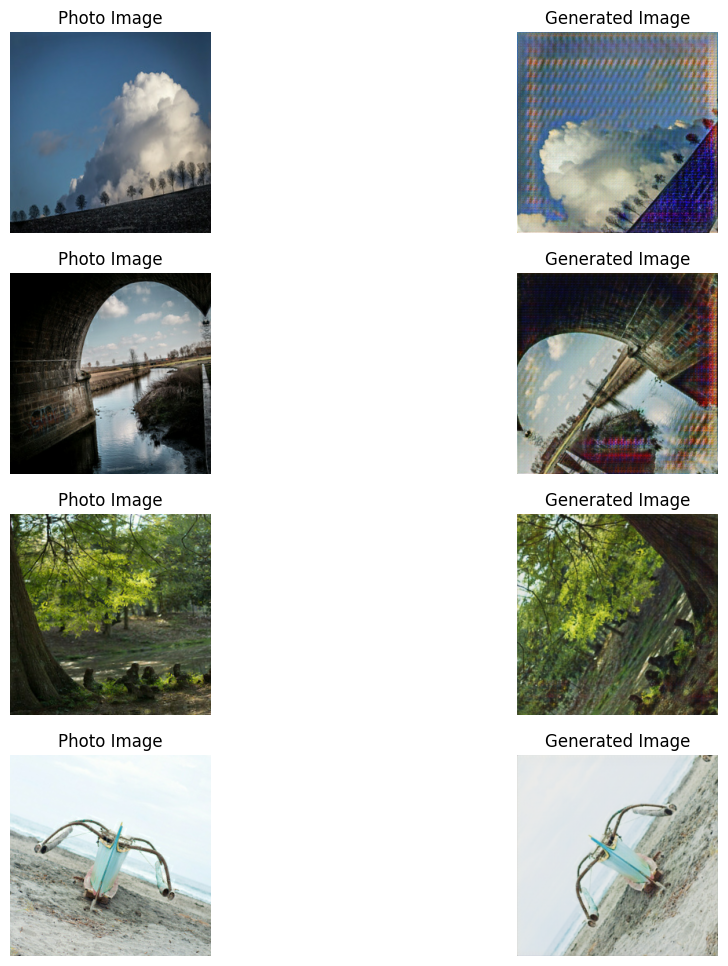

In [16]:
import matplotlib.pyplot as plt

def display_images(real_images, generated_images, num_images=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow((real_images[i] * 0.5 + 0.5))
        plt.title("Photo Image")
        plt.axis("off")

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow((generated_images[i] * 0.5 + 0.5))
        plt.title("Generated Image")
        plt.axis("off")
    plt.show()

real_images = sample_images(photo_ds, 4)
generated_images = sample_images(photo_ds.map(lambda x: monet_generator(x, training=False)), 4)

display_images(real_images, generated_images, 4)

## <span style="color: blue;">🔹 Conclusion</span>

In this project, we built a model to generate Monet-style paintings from photographs using CycleGAN. By following Kaggle's tutorial and incorporating unique improvements like PatchGAN, LSGAN, data augmentation, and early stopping, we trained our model effectively.

**`Training Results`**

- **Epochs**: 31/100

- **Steps**: 500/500

- **Loss Values**:
| Metric               | Value             |
|----------------------|-------------------|
| **monet_disc_loss**  | 0.2263            |
| **monet_gen_loss**   | 1.5336            |
| **photo_disc_loss**  | 0.2002            |
| **photo_gen_loss**   | 1.6227            |

- **FID Score**: 14.853804588317871

**`Positives`**
- The early stopping mechanism prevented overfitting, allowing efficient training completion at 31 epochs.
- Using data augmentation and LSGAN improved the model's generalization and enabled stable learning.
- The FID score of 14.85 indicates a relatively small difference in distribution between the generated images and Monet's paintings.

**`Negatives`**
- The generated images did not sufficiently reflect the expected Monet style.

**`Improvements`**
- Review MiFID Score: Check the calculation method and the model used to ensure accuracy.
- Model Fine-tuning: Adjust the architectures of the generators and discriminators for better style transformation.
- Data Set Review: Increase the training dataset size and include various styles to enhance model learning.
- Hyperparameter Adjustment: Optimize learning rates and batch sizes to find the best training conditions.

**`Create Submission File`**

In [17]:
import PIL
import os
import shutil
from tqdm.notebook import tqdm
import numpy as np
import datetime

output_dir = '../images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(output_dir):
    file_path = os.path.join(output_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

num_images_to_generate = 7000

batch_size = 50

photo_ds_subset = list(photo_ds.take(num_images_to_generate))

all_generated_images = []

def save_generated_images(generated_images, output_dir, start_index):
    for i, img in enumerate(generated_images):
        img = (img * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(img)
        im.save(f"{output_dir}/{start_index + i + 1}.jpg")

try:
    for start in tqdm(range(0, num_images_to_generate, batch_size)):
        end = min(start + batch_size, num_images_to_generate)
        current_batch = []
        for i in range(start, end):
            photo = photo_ds_subset[i]
            photo = tf.reshape(photo, (1, 256, 256, 3))
            generated_image = monet_generator(photo, training=False)[0]
            current_batch.append(generated_image.numpy())

        all_generated_images.extend(current_batch)
        save_generated_images(current_batch, output_dir, start)

except Exception as e:
    print(f"Error occurred while generating images: {e}")

for filename in os.listdir("/kaggle/working"):
    if filename.endswith(".zip"):
        file_path = os.path.join("/kaggle/working", filename)
        try:
            os.remove(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

shutil.make_archive("/kaggle/working/images", 'zip', output_dir)

print("Submission file has been created")

  0%|          | 0/140 [00:00<?, ?it/s]

Submission file has been created
